# PyTorch Crash Course

In [1]:
import torch
import numpy as np

### Tensors

Quick notes:
 - `.item()` used for 1-elt tensors into Python numerical vals
 - any kind of numerical/list+array method you need exists, plus anything from numpy
 - `axis = 0`: column, `axis = 1`: row

In [33]:
data = [[1, 2, 3], [4, 5, 6]]
d1_tensor = torch.tensor(data)

data2 = np.array([[1, 1, 1], [2, 2, 2]])
d2_tensor = torch.from_numpy(data2)

empty = torch.zeros_like(d2_tensor.T)
stacked = torch.cat([d1_tensor, d2_tensor], axis=1)
agg = torch.sum(d1_tensor)
agg_val = agg.item()
print(agg_val) # stack adds dim; vstack/hstack & cat similar

21


### Datasets & Dataloaders

Loading data:
- torchvision is a pytorch library with tools for visual processing
    - also see torchaudio for processing visual inputs, etc
- parameters for fashionMNIST dataset:
    - `root` --> name of directory with inputs
    - `train` --> True = training, else testing
    - `transform` --> function to transform the data with
    - `download` --> download from source if not found in directory

In [2]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True,
)

100%|██████████| 26421880/26421880 [00:27<00:00, 960734.98it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 287917.84it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 541110.15it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12402226.88it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Data visualization
- fashionMNIST specifict, to visualize a random image from each of the samples
    - labeling is library-specific

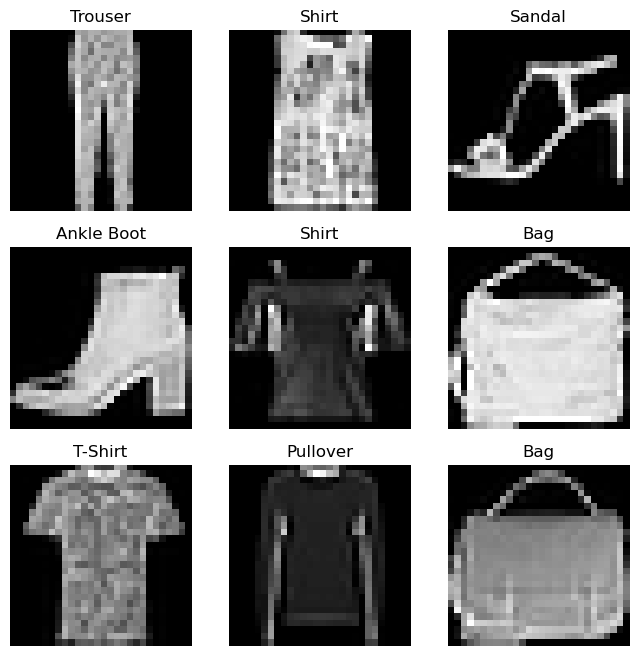

In [35]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, rows*cols + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


Custom datasets
- needs three fns
    - `__init__`: initialize the directory containing the images, the annotations file [labels], and both transforms
    - `len`: number of samples in dataset
    - `getitem(idx)`: return sample at given index converted to tensor (read_image from torchvision), and its label [in tuple]

In [36]:
import os
import pandas as pd
from torchvision.io import read_image


class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


Dataloaders (minibatch samples)
- `DataLoader` is an iterable, uses Python multiprocessing to speed up data retreival
- params:
    - `dataset`
    - `batch_size`: number of samples per batch
    - `shuffle`: bool, s.t. data shuffled each epoch to reduce overfitting [i.e. data shuffled only after all batches have been drawn, so each batch is not independent]

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Iterate through loader
- `next(iter(loader))` gets you the features + labels
- here, sampling first elt in each

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


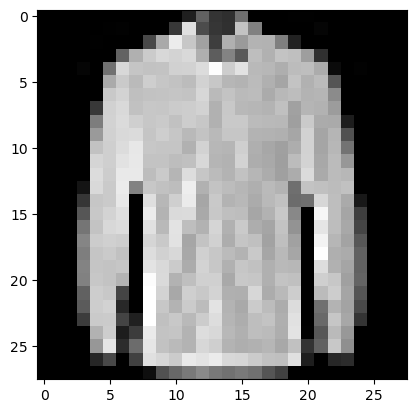

Label: 6


In [38]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


### Transforms

- transform data to be trainable
    - `torchvision.transforms` (common transforms)
    - datasets have parameters:
        - `transform`: modify features (ex: PIL im to tensor uses ToTensor())
        - `target_transform`: modify labels (ex: int to one-hot uses lambda fn)
    - `ToTensor()`: PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]
    

In [39]:
from torchvision.transforms import Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

### Build Neural Network

- Neural network is a `nn.Module` subclass, requiring the following methods:
    - `__init__`: define layers, here including the `flatten` and `linear_relu_stack` operations
    - `forward()`: operations on input data
- To use, create an instance of the class and move it to `device`. Then pass the input data to the model.
    

In [3]:
from torch import nn
from torchvision import transforms

# choose device
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"using {device} device")

# subclass
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# instance of class
model = NeuralNetwork().to(device)
print(model)

# use model
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
# output is 1x10 raw predicted val for each class, passed through softmax for largest prediction
pred_probab = nn.Softmax(dim=1)(logits)
# y_pred = torch.argmax(pred_probab) # argmax doesn't work on mps
y_pred = pred_probab.max(dim=1).indices
print(f"Predicted class: {y_pred}")


using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Predicted class: tensor([1], device='mps:0')


### Backprop

- built-in differentiation engine called `torch.autograd` for any computational graph. HIGH LEVEL:
    - computational graphs are stored as DAGs, leaves as input and root as output
    - `backward()` begins graph generation, then individual `grad_fn`s find the gradients at each step
    - chain rule from root --> leaf propagates gradients to leaves

<img src="dag_comp_graph.png" alt="isolated" width="800"/>

- weights requiring optimization need gd: set for instance `w = torch.randn(5, 3, requires_grad=True)`
    - or if we have tensor already, `w.requires_grad_(True)`
- tensor functions through input --> output are an object of the `Function` class, containing forward and backward methods
    - backward here referred to as `grad_fn`, i.e. `x.grad_fn`
- compute gradient values with `loss.backward()` --> suppose w and b in DAG from x to loss, then the following values are populated
    - dloss/dw: reference with `w.grad`
    - dloss/db: reference with `b.grad`
    - if we need to calculate `backward()` multiple times for one graph, set `retain_graph=True`
- any tensor with `requires_grad=True` automatically tracks gradient through `backward()` calls
    - used for frozen parameters or speed up calculations on forward pass
    - note that each call of `backward()` accumulates gradients (running sum)



In [41]:
# define weights for computational graph
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

# calculate gradients
loss.backward()
print(w.grad)
print(b.grad)

# detach gradient tracking, option 1
print(f"before no_grad: {z.requires_grad}")
with torch.no_grad():
    z = torch.matmul(x, w)+b
print(f"after no_grad: {z.requires_grad}")
# option 2
z = torch.matmul(x, w)+b
z_det = z.detach()
print(f"before detaching: {z.requires_grad}")
print(f"after detaching: {z_det.requires_grad}")


tensor([[0.0912, 0.2442, 0.0118],
        [0.0912, 0.2442, 0.0118],
        [0.0912, 0.2442, 0.0118],
        [0.0912, 0.2442, 0.0118],
        [0.0912, 0.2442, 0.0118]])
tensor([0.0912, 0.2442, 0.0118])
before no_grad: True
after no_grad: False
before detaching: True
after detaching: False


### Training & Testing

- parameters:
    - epochs, batch size (# samples before update), learning rate
- each epoch consists of training loop + validation loop
- training: attempt for convergence
    - loss functions: MSE (`nn.MSELoss`), NLL (binary class, `nn.NLLLoss`), CrossEntropy (softmax + NLL = multiclass, `nn.CrossEntropyLoss`)
    - optimizer adjusts parameters at each training step: SGD, Adam, Adadelta
        - reset gradients to 0 to avoid double-counting, backprop, `optimizer.step()` to adjust parameters
- validation: evaluate parameter values for performance

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.max(dim=1).indices == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# parameters
learning_rate = 1e-3
batch_size = 64
epochs = 5


# implementation
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.306772  [   64/60000]
loss: 2.288403  [ 6464/60000]
loss: 2.269019  [12864/60000]
loss: 2.259218  [19264/60000]
loss: 2.238270  [25664/60000]
loss: 2.213049  [32064/60000]
loss: 2.200850  [38464/60000]
loss: 2.169021  [44864/60000]
loss: 2.161138  [51264/60000]
loss: 2.132468  [57664/60000]
Test Error: 
 Accuracy: 56.4%, Avg loss: 2.133193 

Epoch 2
-------------------------------
loss: 2.136014  [   64/60000]
loss: 2.109132  [ 6464/60000]
loss: 2.087736  [12864/60000]
loss: 2.038505  [19264/60000]
loss: 2.010488  [25664/60000]
loss: 2.019046  [32064/60000]
loss: 1.965232  [38464/60000]
loss: 1.883005  [44864/60000]
loss: 1.897850  [51264/60000]
loss: 1.856880  [57664/60000]
Test Error: 
 Accuracy: 59.8%, Avg loss: 1.843978 

Epoch 3
-------------------------------
loss: 1.848179  [   64/60000]
loss: 1.823833  [ 6464/60000]
loss: 1.711603  [12864/60000]
loss: 1.681956  [19264/60000]
loss: 1.646641  [25664/60000]
loss: 1.690430  [32064/600

### Save & Load Model

NOTE: this section uses arbitrary model, not model trained above
- pytorch saves models in `state_dict` (internal state dictionary)
    - persist using `torch.save()`
- to use/load weights, create an instance of the model first
    - load from `state_dict` using `load_state_dict()`

In [44]:
# import torchvision.models as models

# # save
# model = models.vgg16(weights='IMAGENET1K_V1') # arbitrary model of vgg16 class
# torch.save(model.state_dict(), 'model_weights.pth')

# # load
# model = models.vgg16() # default class preloading with untrained weights
# model.load_state_dict(torch.load('model_weights.pth'))
# model.eval() # set model in eval mode: drop normalization & dropout layers

# # saving and loading a custom model class, using pickling (less reliable, in case your model class changes btwn save/load)
# # torch.save(model, 'model.pth')
# # model = torch.load('model.pth')


Usign our FashionMNIST trained model:

In [8]:
# save fashionMNIST model
torch.save(model.state_dict(), 'fashion_model_wts.pth')

# load fashionMNIST model
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('fashion_model_wts.pth'))
model.eval() # set to testing mode

# [copied from above ] use model
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
# output is 1x10 raw predicted val for each class, passed through softmax for largest prediction
pred_probab = nn.Softmax(dim=1)(logits)
# y_pred = torch.argmax(pred_probab) # argmax doesn't work on mps
y_pred = pred_probab.max(dim=1).indices
print(f"Predicted class: {y_pred}")

Predicted class: tensor([8], device='mps:0')
